# Preprocessing and Training Data Development - Football Transfer Evaluation

We will continue the work in the previous notebook and look to produce the features that we will use in creating our model. In order to get all our features set, we need to identify our categorical data vs. numerical data and create a clean, useable data set for our model. We start by having a look again at our data, found in the football_data_eda csv file

In [299]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('football_data_eda.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157323 entries, 0 to 157322
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Unnamed: 0              157323 non-null  int64  
 1   player_id               157323 non-null  int64  
 2   player_name             157323 non-null  object 
 3   season                  157323 non-null  int64  
 4   club_name               157323 non-null  object 
 5   minutes_played          157323 non-null  int64  
 6   goal_contributions      157323 non-null  float64
 7   minutes_per_appearance  157323 non-null  int64  
 8   position                157323 non-null  object 
 9   nationality_code        157323 non-null  object 
 10  date_of_birth           157323 non-null  object 
 11  height                  157323 non-null  float64
 12  market_value            77661 non-null   float64
 13  fee                     69582 non-null   float64
 14  league              

Our categorical data consists of the columns:
* club_name
* position
* nationality_code
* league

Additionally, we will need to reintroduce age of players each season from the previous. We will start with this step, then work through the remaining categorical data to create dummy variables across each.

In [300]:
df['age'] = df['season'] - pd.DatetimeIndex(df['date_of_birth']).year
df['age'].describe()

count    157323.000000
mean         25.256568
std           4.777840
min           5.000000
25%          22.000000
50%          25.000000
75%          29.000000
max          45.000000
Name: age, dtype: float64

We see that at least one player is listed as 5 years old, which is definitely not correct. We will fix this now to see if we can correct this data through removal or other means.

In [301]:
df = df[df['age'] > 14]
df['age'].describe()

count    157296.000000
mean         25.258583
std           4.775720
min          15.000000
25%          22.000000
50%          25.000000
75%          29.000000
max          45.000000
Name: age, dtype: float64

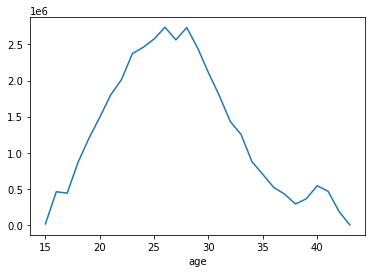

In [302]:
df.groupby('age')['market_value'].mean().plot()

Now, we will create dummy variables for position, nationality, and league. We will start with positions, which we grouped in the previous notebooks based on the area of the field that the players played in.

In [303]:
df['position'].unique()

array(['S', 'CM', 'CB', 'GK', 'RM', 'LM', 'CDM', 'CAM', 'RB', 'LB'],
      dtype=object)

In [304]:
df_copy = df.copy()

In [305]:
pos_dummies = pd.get_dummies(df['position'],drop_first=True)
df_copy = pd.concat([df_copy, pos_dummies], axis=1)

df_copy.head()

,Unnamed: 0,player_id,player_name,season,club_name,minutes_played,goal_contributions,minutes_per_appearance,position,nationality_code,...,age,CB,CDM,CM,GK,LB,LM,RB,RM,S
0,0,1,Jermaine Beckford,2005,Leeds United,137,0.0,27,S,JAM,...,22,0,0,0,0,0,0,0,0,1
1,1,1,Jermaine Beckford,2006,Carlisle United,1979,12.0,73,S,JAM,...,23,0,0,0,0,0,0,0,0,1
2,5,1,Jermaine Beckford,2007,Leeds United,3789,21.0,84,S,JAM,...,24,0,0,0,0,0,0,0,0,1
3,6,1,Jermaine Beckford,2008,Leeds United,3283,35.0,80,S,JAM,...,25,0,0,0,0,0,0,0,0,1
4,7,1,Jermaine Beckford,2009,Leeds United,4184,39.0,82,S,JAM,...,26,0,0,0,0,0,0,0,0,1


Next, we move to nationalities, which are stored as 3 Letter codes used by international federations in identifying teams for competition. For example, "United States of America" is simply "USA". We would like to create dummy variables for these countries, but it may be too much to create dummy variables for all countries. Thus, we will instead create a column that lists the country code by federation, then create dummy variables by federation. This will group African (CAF), Asian (AFC), European (UEFA), North and Central American (CONCACAF), South American (COMNEBOL), as well as Oceania (OFC). To do this, we will 

In [306]:
url = 'https://en.wikipedia.org/wiki/Asian_Football_Confederation'

afc = pd.read_html(url)[2]['Code']
afc.rename(columns = {'West Asian Football Federation (WAFF) (12)':'Asia'}, inplace=True)

asia = list(afc[afc['Asia'].str.len() == 3]['Asia'])
asia[:5]

['BHR', 'IRQ', 'JOR', 'KUW', 'LBN']

In [307]:
url = 'https://en.wikipedia.org/wiki/Confederation_of_African_Football'

caf = pd.read_html(url)[4]['Code']
caf.rename(columns = {'Union of North African Football Federations (UNAF) (5)':'Africa'}, inplace=True)

africa = list(caf[caf['Africa'].str.len() == 3]['Africa'])
africa[:5]

['ALG', 'EGY', 'LBY', 'MAR', 'TUN']

In [308]:
url = 'https://en.wikipedia.org/wiki/UEFA'

europe = pd.read_html(url)[4]['Code']
europe = list(europe)

europe[:5]

['ALB', 'AND', 'ARM', 'AUT', 'AZE']

In [309]:
url = 'https://en.wikipedia.org/wiki/CONMEBOL'

s_america = pd.read_html(url)[3]['Code']

s_america = list(s_america)

s_america[:5]

['ARG', 'BOL', 'BRA', 'CHI', 'COL']

In [310]:
url = 'https://en.wikipedia.org/wiki/CONCACAF'

n_america = pd.read_html(url)[3]['Code']

n_america.rename(columns={'North American Zone (NAFU) (3)': 'North_America'}, inplace=True)

n_america = list(n_america[n_america['North_America'].str.len() == 3]['North_America'])

n_america[:5]

['CAN', 'MEX', 'USA', 'BLZ', 'CRC']

In [311]:
df['region'] = 'Other'
df.loc[df["nationality_code"].isin(europe), "region"] = "Europe"
df.loc[df["nationality_code"].isin(asia), "region"] = "Asia"
df.loc[df["nationality_code"].isin(africa), "region"] = "Africa"
df.loc[df["nationality_code"].isin(n_america), "region"] = "North_America"
df.loc[df["nationality_code"].isin(s_america), "region"] = "South_America"

df['region'].unique()

array(['North_America', 'Europe', 'Other', 'Africa', 'Asia',
       'South_America'], dtype=object)

In [312]:
pos_dummies = pd.get_dummies(df['region'],drop_first=True)
df_copy = pd.concat([df_copy, pos_dummies], axis=1)

df_copy.head()

,Unnamed: 0,player_id,player_name,season,club_name,minutes_played,goal_contributions,minutes_per_appearance,position,nationality_code,...,LB,LM,RB,RM,S,Asia,Europe,North_America,Other,South_America
0,0,1,Jermaine Beckford,2005,Leeds United,137,0.0,27,S,JAM,...,0,0,0,0,1,0,0,1,0,0
1,1,1,Jermaine Beckford,2006,Carlisle United,1979,12.0,73,S,JAM,...,0,0,0,0,1,0,0,1,0,0
2,5,1,Jermaine Beckford,2007,Leeds United,3789,21.0,84,S,JAM,...,0,0,0,0,1,0,0,1,0,0
3,6,1,Jermaine Beckford,2008,Leeds United,3283,35.0,80,S,JAM,...,0,0,0,0,1,0,0,1,0,0
4,7,1,Jermaine Beckford,2009,Leeds United,4184,39.0,82,S,JAM,...,0,0,0,0,1,0,0,1,0,0


Now, our df_copy has dummy variables for positions and regions. We need to now fill our league dummy variables last. For this, I have decided to use the divisions that I had before, where I split the leagues into groups. These groups will be as follows:

* Tier 1: England, Italy, Spain
* Tier 2: Germany, France, Russia, Portugal
* Tier 3: Netherlands, Turkey, Belgium
* Tier 4: Others

This can help us keep the similarities between each group that we saw in our EDA.

In [313]:
df['league'].unique()

array(['Other League', 'Liga NOS', 'Ligue 1', 'Eredivisie', 'Süper Lig',
       'Premier League', 'Premier Liga', 'Bundesliga', 'Serie A',
       'LaLiga', 'Jupiler Pro League'], dtype=object)

In [314]:
tier_1 = ['Premier League', 'Serie A', 'LaLiga']
tier_2 = ['Liga NOS', 'Ligue 1', 'Premier Liga', 'Bundesliga']
tier_3 = ['Eredivisie', 'Süper Lig','Jupiler Pro League']

df['league_class'] = 'Tier_4'
df.loc[df["league"].isin(tier_1), "league_class"] = "Tier_1"
df.loc[df["league"].isin(tier_2), "league_class"] = "Tier_2"
df.loc[df["league"].isin(tier_3), "league_class"] = "Tier_3"

df['league_class'].unique()

array(['Tier_4', 'Tier_2', 'Tier_3', 'Tier_1'], dtype=object)

In [315]:
pos_dummies = pd.get_dummies(df['league_class'],drop_first=True)
df_copy = pd.concat([df_copy, pos_dummies], axis=1)

df_copy.head()

,Unnamed: 0,player_id,player_name,season,club_name,minutes_played,goal_contributions,minutes_per_appearance,position,nationality_code,...,RM,S,Asia,Europe,North_America,Other,South_America,Tier_2,Tier_3,Tier_4
0,0,1,Jermaine Beckford,2005,Leeds United,137,0.0,27,S,JAM,...,0,1,0,0,1,0,0,0,0,1
1,1,1,Jermaine Beckford,2006,Carlisle United,1979,12.0,73,S,JAM,...,0,1,0,0,1,0,0,0,0,1
2,5,1,Jermaine Beckford,2007,Leeds United,3789,21.0,84,S,JAM,...,0,1,0,0,1,0,0,0,0,1
3,6,1,Jermaine Beckford,2008,Leeds United,3283,35.0,80,S,JAM,...,0,1,0,0,1,0,0,0,0,1
4,7,1,Jermaine Beckford,2009,Leeds United,4184,39.0,82,S,JAM,...,0,1,0,0,1,0,0,0,0,1


Our last categorical information is given by the club name, but I believe we have this information roughly stored in the league class dummy variables now, so we can drop this column from our dataframe.

In [316]:
df_copy.drop(columns='club_name', inplace=True)

df_copy.head()

,Unnamed: 0,player_id,player_name,season,minutes_played,goal_contributions,minutes_per_appearance,position,nationality_code,date_of_birth,...,RM,S,Asia,Europe,North_America,Other,South_America,Tier_2,Tier_3,Tier_4
0,0,1,Jermaine Beckford,2005,137,0.0,27,S,JAM,1983-12-09,...,0,1,0,0,1,0,0,0,0,1
1,1,1,Jermaine Beckford,2006,1979,12.0,73,S,JAM,1983-12-09,...,0,1,0,0,1,0,0,0,0,1
2,5,1,Jermaine Beckford,2007,3789,21.0,84,S,JAM,1983-12-09,...,0,1,0,0,1,0,0,0,0,1
3,6,1,Jermaine Beckford,2008,3283,35.0,80,S,JAM,1983-12-09,...,0,1,0,0,1,0,0,0,0,1
4,7,1,Jermaine Beckford,2009,4184,39.0,82,S,JAM,1983-12-09,...,0,1,0,0,1,0,0,0,0,1


In [317]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157296 entries, 0 to 157322
Data columns (total 32 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Unnamed: 0              157296 non-null  int64  
 1   player_id               157296 non-null  int64  
 2   player_name             157296 non-null  object 
 3   season                  157296 non-null  int64  
 4   minutes_played          157296 non-null  int64  
 5   goal_contributions      157296 non-null  float64
 6   minutes_per_appearance  157296 non-null  int64  
 7   position                157296 non-null  object 
 8   nationality_code        157296 non-null  object 
 9   date_of_birth           157296 non-null  object 
 10  height                  157296 non-null  float64
 11  market_value            77659 non-null   float64
 12  fee                     69580 non-null   float64
 13  league                  157296 non-null  object 
 14  age                 

In [318]:
df_copy.drop(columns=['league', 'position', 'nationality_code'], inplace=True)

In [319]:
df_copy['date_of_birth'] = pd.to_datetime(df_copy['date_of_birth'])
df_copy.drop(columns = 'player_name')
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157296 entries, 0 to 157322
Data columns (total 29 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Unnamed: 0              157296 non-null  int64         
 1   player_id               157296 non-null  int64         
 2   player_name             157296 non-null  object        
 3   season                  157296 non-null  int64         
 4   minutes_played          157296 non-null  int64         
 5   goal_contributions      157296 non-null  float64       
 6   minutes_per_appearance  157296 non-null  int64         
 7   date_of_birth           157296 non-null  datetime64[ns]
 8   height                  157296 non-null  float64       
 9   market_value            77659 non-null   float64       
 10  fee                     69580 non-null   float64       
 11  age                     157296 non-null  int64         
 12  CB                      157296

In [320]:
df_copy.rename(columns = {'Unnamed: 0':'Index'},inplace=True)
df_copy.set_index('Index', inplace=True)
df_copy.head()

,player_id,player_name,season,minutes_played,goal_contributions,minutes_per_appearance,date_of_birth,height,market_value,fee,...,RM,S,Asia,Europe,North_America,Other,South_America,Tier_2,Tier_3,Tier_4
Index,,,,,,,,,,,,,,,,,,,,,
0,1,Jermaine Beckford,2005,137,0.0,27,1983-12-09,188.0,0.0,0.0,...,0,1,0,0,1,0,0,0,0,1
1,1,Jermaine Beckford,2006,1979,12.0,73,1983-12-09,188.0,100000.0,0.0,...,0,1,0,0,1,0,0,0,0,1
5,1,Jermaine Beckford,2007,3789,21.0,84,1983-12-09,188.0,NaN,NaN,...,0,1,0,0,1,0,0,0,0,1
6,1,Jermaine Beckford,2008,3283,35.0,80,1983-12-09,188.0,NaN,NaN,...,0,1,0,0,1,0,0,0,0,1
7,1,Jermaine Beckford,2009,4184,39.0,82,1983-12-09,188.0,NaN,NaN,...,0,1,0,0,1,0,0,0,0,1


In [321]:
df_copy['fee'].fillna(0, inplace=True)
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157296 entries, 0 to 698949
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   player_id               157296 non-null  int64         
 1   player_name             157296 non-null  object        
 2   season                  157296 non-null  int64         
 3   minutes_played          157296 non-null  int64         
 4   goal_contributions      157296 non-null  float64       
 5   minutes_per_appearance  157296 non-null  int64         
 6   date_of_birth           157296 non-null  datetime64[ns]
 7   height                  157296 non-null  float64       
 8   market_value            77659 non-null   float64       
 9   fee                     157296 non-null  float64       
 10  age                     157296 non-null  int64         
 11  CB                      157296 non-null  uint8         
 12  CDM                     157296

In [329]:
# Fixing the data where height is obviously incorrect. After checking values, all players with these extremes are 
# roughly 200 cm
df_copy.loc[(df_copy['height'] < 100),'height'] = 200
df_copy.loc[(df_copy['height'] > 210),'height'] = 210

In [330]:
df_copy.describe()

,player_id,season,minutes_played,goal_contributions,minutes_per_appearance,height,market_value,fee,age,CB,...,RM,S,Asia,Europe,North_America,Other,South_America,Tier_2,Tier_3,Tier_4
count,157296.000000,157296.000000,157296.000000,157296.000000,157296.000000,157296.000000,7.765900e+04,1.572960e+05,157296.000000,157296.000000,...,157296.000000,157296.000000,157296.000000,157296.000000,157296.000000,157296.000000,157296.000000,157296.000000,157296.000000,157296.000000
mean,5511.414124,2010.163316,1586.240089,4.182261,69.303708,181.945296,2.051719e+06,4.941834e+05,25.258583,0.180310,...,0.070790,0.205943,0.017159,0.459910,0.019403,0.307274,0.110728,0.101153,0.072863,0.734615
std,3264.825158,5.479178,1116.161011,6.045446,20.230304,6.339067,3.763617e+06,2.814879e+06,4.775720,0.384446,...,0.256475,0.404390,0.129863,0.498392,0.137937,0.461365,0.313795,0.301532,0.259912,0.441539
min,1.000000,1984.000000,1.000000,0.000000,0.000000,159.000000,0.000000e+00,0.000000e+00,15.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2656.000000,2007.000000,592.000000,0.000000,58.000000,178.000000,4.000000e+05,0.000000e+00,22.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5467.000000,2011.000000,1470.000000,2.000000,75.000000,182.000000,1.000000e+06,0.000000e+00,25.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,8316.000000,2015.000000,2455.000000,6.000000,85.000000,186.000000,2.000000e+06,0.000000e+00,29.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,11382.000000,2019.000000,5799.000000,102.000000,150.000000,210.000000,1.200000e+08,2.220000e+08,45.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Training the Data

We have now created features for our data, stored in df_copy. We still have null values in roughly half the data set. Our goal is to predict market value, so we will treat the null values as our test data, and use the remaining data to form our training set.

In [335]:
prediction_data = df_copy[df_copy['market_value'].isnull()]
prediction_data = prediction_data.drop(columns=['player_name','date_of_birth'])
prediction_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79637 entries, 5 to 698949
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   player_id               79637 non-null  int64  
 1   season                  79637 non-null  int64  
 2   minutes_played          79637 non-null  int64  
 3   goal_contributions      79637 non-null  float64
 4   minutes_per_appearance  79637 non-null  int64  
 5   height                  79637 non-null  float64
 6   market_value            0 non-null      float64
 7   fee                     79637 non-null  float64
 8   age                     79637 non-null  int64  
 9   CB                      79637 non-null  uint8  
 10  CDM                     79637 non-null  uint8  
 11  CM                      79637 non-null  uint8  
 12  GK                      79637 non-null  uint8  
 13  LB                      79637 non-null  uint8  
 14  LM                      79637 non-nul

In [336]:
training_data = df_copy.dropna()
training_data.drop(columns=['player_name','date_of_birth'], inplace=True)
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77659 entries, 0 to 698948
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   player_id               77659 non-null  int64  
 1   season                  77659 non-null  int64  
 2   minutes_played          77659 non-null  int64  
 3   goal_contributions      77659 non-null  float64
 4   minutes_per_appearance  77659 non-null  int64  
 5   height                  77659 non-null  float64
 6   market_value            77659 non-null  float64
 7   fee                     77659 non-null  float64
 8   age                     77659 non-null  int64  
 9   CB                      77659 non-null  uint8  
 10  CDM                     77659 non-null  uint8  
 11  CM                      77659 non-null  uint8  
 12  GK                      77659 non-null  uint8  
 13  LB                      77659 non-null  uint8  
 14  LM                      77659 non-nul

C:\Users\david\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Now that we have finished creating dummy variables, we will now look to scale our data in order to have it ready for creating training and testing sets. For this, we will use the StandardScaler package from sklearn.

In [339]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
scaled_data = scaler.fit_transform(training_data)

scaled_data = pd.DataFrame(scaled_data, columns=training_data.columns)

X = scaled_data.drop(columns='market_value')
y = scaled_data['market_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.describe()

,player_id,season,minutes_played,goal_contributions,minutes_per_appearance,height,fee,age,CB,CDM,...,RM,S,Asia,Europe,North_America,Other,South_America,Tier_2,Tier_3,Tier_4
count,62127.000000,62127.000000,62127.000000,62127.000000,62127.000000,62127.000000,62127.000000,62127.000000,62127.000000,62127.000000,...,62127.000000,62127.000000,62127.000000,62127.000000,62127.000000,62127.000000,62127.000000,62127.000000,62127.000000,62127.000000
mean,0.000136,0.001729,0.002089,0.002182,0.001280,-0.002030,-0.000875,0.002951,0.000383,0.002747,...,0.000246,0.000433,0.000831,0.000586,0.001976,0.000016,0.000011,0.001448,0.001316,-0.001483
std,1.001231,0.998928,1.003308,1.003687,0.999202,0.999587,1.014000,1.001092,1.000354,1.004005,...,1.000406,1.000259,1.003141,1.000077,1.006752,1.000016,1.000020,1.002096,1.002119,1.000866
min,-1.750521,-5.070750,-1.344931,-0.702485,-3.295223,-3.616206,-0.253902,-2.370182,-0.444325,-0.309683,...,-0.283837,-0.576622,-0.130122,-0.889189,-0.142989,-0.639119,-0.391171,-0.312471,-0.285897,-1.735074
25%,-0.865139,-0.744179,-0.857879,-0.702485,-0.607024,-0.628194,-0.253902,-0.812750,-0.444325,-0.309683,...,-0.283837,-0.576622,-0.130122,-0.889189,-0.142989,-0.639119,-0.391171,-0.312471,-0.285897,0.576344
50%,-0.000204,0.121136,-0.183118,-0.337746,0.272750,0.000861,-0.253902,-0.145279,-0.444325,-0.309683,...,-0.283837,-0.576622,-0.130122,-0.889189,-0.142989,-0.639119,-0.391171,-0.312471,-0.285897,0.576344
75%,0.857762,0.770121,0.715904,0.209361,0.810390,0.629916,-0.203170,0.744682,-0.444325,-0.309683,...,-0.283837,-0.576622,-0.130122,1.124620,-0.142989,1.564653,-0.391171,-0.312471,-0.285897,0.576344
max,1.775207,1.635435,4.018575,10.239662,4.036229,4.404247,56.058740,3.859546,2.250603,3.229112,...,3.523153,1.734239,7.685122,1.124620,6.993524,1.564653,2.556427,3.200296,3.497760,0.576344


We now have our training and test split among the data from our original dataframe containing all rows with values for market value as not null. We will save these data sets now and use them in our next notebook, where we create and run our models.

In [341]:
prediction_data.to_csv("prediction.csv", index=False)
scaled_data.to_csv("scaled_training.csv", index=False)
training_data.to_csv("training.csv",index=False)